In [94]:
import random
import seaborn as sns
import numpy as np
from numpy.random import uniform
from numpy import multiply
from scipy.ndimage.filters import gaussian_filter

import matplotlib.pyplot as plt
%matplotlib inline

from mesa import Model, Agent
from mesa.time import RandomActivation
from mesa.space import Grid
from mesa.datacollection import DataCollector
from mesa.batchrunner import BatchRunner

#### About

It's a simple adaptation of [Forest Fire model]("https://github.com/projectmesa/mesa/tree/master/examples/forest_fire") created by Kazil & Vērzemnieks. The difference is that in addition with tulp and density of the grid, I apply height to each cell. According to the theory, trees located higher from the start are more likely to be burned than those growing on lower altitude. For the sake of simplicity, I keep crisp outcomes.

Code for creating hypthetical terrain was adapted from [Farmer]("https://gist.github.com/carsonfarmer/c10bbf5706bdc26feef79f2428dd9dc6")

At first, let's create a hypothetical surface on 100x100 grid. The attributes which later will be passed to  ```agent``` are stored into separate array ```surf```

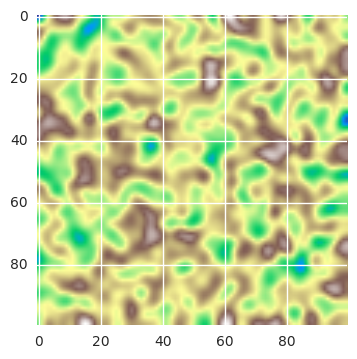

In [134]:
def surf_function(dim=(100,100), low=500, high=1000, sigma=2):
    r = uniform(low, high, size=multiply(*dim)).reshape(dim)
    return gaussian_filter(r, sigma=sigma, truncate=9)
plt.imshow(fake_surface((100,100)), cmap=plt.get_cmap("terrain"))
plt.show()
surf=surf_function()

The code below defines agent. Apart from the density of the tree cover, I employ the height of the cell ```hght```.

In [135]:
class TreeCell(Agent):

    def __init__(self, pos, model):

        Agent.__init__(self, pos, model)
        self.pos = pos
        self.condition = "Fine"
        self.hght = surf[pos]

    def step(self):

        if self.condition == "On Fire":
            for neighbor in self.model.grid.neighbor_iter(self.pos):
                if neighbor.condition == "Fine" and neighbor.hght>=self.hght:
                    neighbor.condition = "On Fire"
            self.condition = "Burned Out"
        
    def get_pos(self):
        return self.pos

In [136]:
class ForestFire(Model):

    def __init__(self, height, width, density):
        self.height = height
        self.width = width
        self.density = density
        self.schedule = RandomActivation(self)
        self.grid = Grid(height, width, torus=False)
        
        
        self.datacollector = DataCollector(
            {"Fine": lambda m: self.count_type(m, "Fine"),
             "On Fire": lambda m: self.count_type(m, "On Fire"),
             "Burned Out": lambda m: self.count_type(m, "Burned Out")})

        for (contents, x, y) in self.grid.coord_iter():
            if random.random() < self.density:
                new_tree = TreeCell((x, y), self)
                if x == 0:
                    new_tree.condition = "On Fire"
                self.grid._place_agent((x, y), new_tree)
                self.schedule.add(new_tree)
        self.running = True
    def step(self):
        self.schedule.step()
        self.datacollector.collect(self)
        if self.count_type(self, "On Fire") == 0:
            self.running = False

    @staticmethod
    def count_type(model, tree_condition):
        count = 0
        for tree in model.schedule.agents:
            if tree.condition == tree_condition:
                count += 1
        return count

Run the model on a densely populated land plot, with dimensions 100 x 100. It looks that considering the characteristics of the terrain has quite profound effect on the model. 

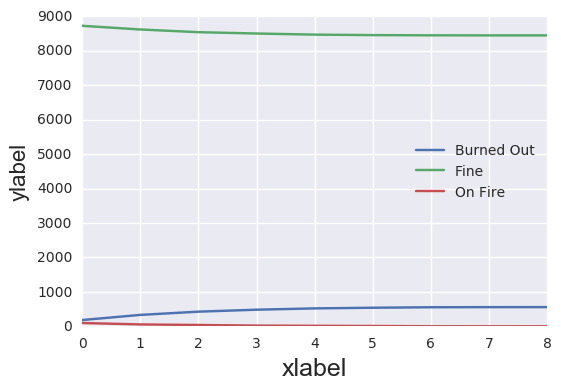

In [142]:
fire=ForestFire(100, 100, 0.9)
fire.run_model()
results = fire.datacollector.get_model_vars_dataframe()
results.plot()
plt.xlabel('Steps', fontsize=12)
plt.ylabel('Number of Trees', fontsize=12)
plt.show()

Even when iterating the densities, significant proportion of the surface stays unburned:

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:09<00:00,  4.65it/s]


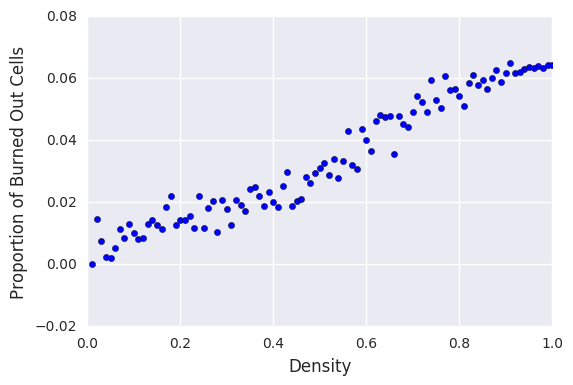

In [144]:
param_set = dict(height=100,
                 width=100,
                 # Vary density from 0.01 to 1, in 0.01 increments:
                 density=np.linspace(0,1,101)[1:])
# At the end of each model run, calculate the fraction of trees which are Burned Out
model_reporter = {"BurnedOut": lambda m: (ForestFire.count_type(m, "Burned Out") / 
                                          m.schedule.get_agent_count()) }
param_run = BatchRunner(ForestFire, param_set, model_reporters=model_reporter)

param_run.run_all()
df = param_run.get_model_vars_dataframe()
plt.scatter(df.density, df.BurnedOut)
plt.xlim(0,1)
plt.xlabel('Density', fontsize=12)
plt.ylabel('Proportion of Burned Out Cells', fontsize=12)
plt.show()